In [1]:
import json

import numpy as np
import matplotlib.pylab as plt

from multistate_extrusion.generators.Translocator import Translocator

from multistate_extrusion.engines.StaticBoundary import StaticBoundary
from multistate_extrusion.engines.MultistateSymmetricExtruder import MultistateSymmetricExtruder

# Extrusion dictionary

In [2]:
sequence = ('RN', 'RB', 'RP', 'RW')

In [3]:
sequence_string = "_".join(sequence)

with open(f"../data/extrusion_dict_{sequence_string}.json", 'r') as dict_file:
    paramdict = json.load(dict_file)


In [4]:
monomers_per_replica = paramdict['monomers_per_replica'] 
sites_per_monomer = paramdict['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer

In [5]:
# Work with a single type of monomers (A, assigned to type index 0)
type_list = ['A']

monomer_types = type_list.index('A') * np.ones(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)

In [6]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_off_rate = paramdict['LEF_off_rate']
CTCF_facestall = paramdict['CTCF_facestall']

print(LEF_off_rate['A'], CTCF_facestall['A'])

0.009176225234619396 1.0


# Making extruders

In [7]:
# Create some CTCF boundary sites
tad_size = 200 # in monomers

ctcf_left_positions = np.arange(0, sites_per_replica, tad_size*sites_per_monomer)
ctcf_right_positions = np.arange(0, sites_per_replica, tad_size*sites_per_monomer)

In [8]:
translocator = Translocator(MultistateSymmetricExtruder,
                            StaticBoundary,
                            type_list, 
                            site_types,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **paramdict)

# Running the simulation

## State equilibration

In [9]:
simulation_time = int(3600 / translocator.time_unit)
LEF_states = []

for _ in range(simulation_time):
    translocator.engine.step()
    LEF_states.append(translocator.engine.states.copy())

In [10]:
LEF_states = np.asarray(LEF_states)
state_counts = np.zeros((len(LEF_states), 5))

for i in range(5):
    state_counts[:, i] = np.count_nonzero(LEF_states==i, axis=1)

In [11]:
data_ODE = np.genfromtxt(f"../data/state_kinetics_{sequence_string}.res")

times_ODE, state_counts_ODE = data_ODE[:, 0], data_ODE[:, 1:6]

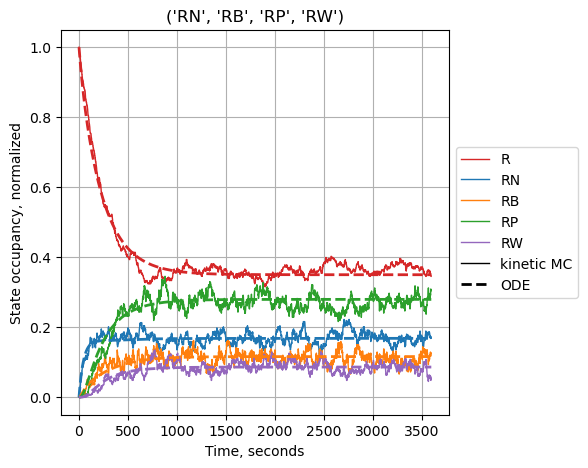

In [12]:
figwidth = 5

times = np.arange(simulation_time) * translocator.time_unit
state_list = ['R'] + list(sequence)

fig = plt.figure(figsize=(figwidth, figwidth)) 

ax = plt.subplot(1,1,1)
ax.set_prop_cycle('color', ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd'])

plt.plot(times[:, None], state_counts/state_counts[0, 0], lw=1)

plt.plot([], [], 'k', lw=1) 
plt.plot([], [], 'k--', lw=2) 

ax.legend(state_list + ['kinetic MC', 'ODE'], shadow=False, loc='center left', bbox_to_anchor=(1, 0.5))

plt.plot(times_ODE[:, None], state_counts_ODE/state_counts_ODE[0, 0], lw=2, ls="--")

plt.title(sequence)

plt.grid(True)

_ = plt.xlabel('Time, seconds')
_ = plt.ylabel('State occupancy, normalized')

## Production run

In [13]:
translocator.run()

In [14]:
# Use run-length encoding to check the residence times of cohesin and regulators
def rle(state_bool_array):
    if len(state_bool_array) > 1:
        transitions = np.diff(state_bool_array)

        starts = np.flatnonzero(transitions)
        lengths = np.diff(starts)

        return starts, lengths

    else:
        return [], []

In [15]:
LEF_states = np.asarray(translocator.state_trajectory)

for state_id, state in enumerate(state_list):
    lifetimes = []

    for lef in range(translocator.engine.num_LEF):
        state_bool_array = (LEF_states[:, lef] == state_id)
        starts, lengths = rle(state_bool_array)

        if state_bool_array[starts[0]]:
            binding_times = lengths[1::2] if state_id > 0 else lengths[::2]
        else:
            binding_times = lengths[::2] if state_id > 0 else lengths[1::2]

        if len(binding_times) > 0:
            lifetimes.append(binding_times.mean())

    mean_lifetime = np.mean(lifetimes) if len(lifetimes) > 0 else 0

    print("Mean %s lifetime: %.2f s" % (state[-1], mean_lifetime * translocator.time_unit))

Mean R lifetime: 822.17 s
Mean N lifetime: 72.15 s
Mean B lifetime: 26.19 s
Mean P lifetime: 69.93 s
Mean W lifetime: 44.97 s


In [16]:
hist = []
frac_active_LEFs = np.zeros(translocator.params['steps'])

for i, lef_pos in enumerate(translocator.lef_trajectory):
    lef_state = translocator.state_trajectory[i]
    frac_active_LEFs[i] = np.count_nonzero(lef_state == paramdict['LEF_states']['RN']) / float(translocator.engine.num_LEF)

    hist.extend(lef_pos)

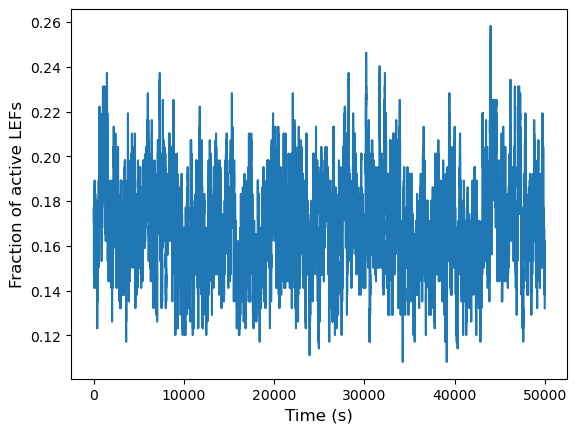

In [17]:
times = np.arange(translocator.params['steps']) * translocator.time_unit

plt.plot(times, frac_active_LEFs)
          
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Fraction of active LEFs', fontsize=12)

plt.show()

# Kymograph Analysis

In [18]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset, sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

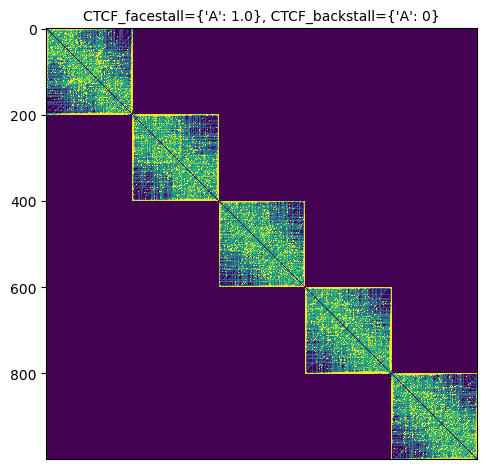

In [19]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False) 
            
plt.title('CTCF_facestall=%s, CTCF_backstall=%s' % (paramdict['CTCF_facestall'],
                                                    paramdict['CTCF_backstall']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
